# Load Packages

In [2]:
using GaussQuadrature, ChebyshevApprox
using Optim, Plots, Statistics
using ProgressMeter
using .Threads

In [3]:
nthreads()

4

# Define Model Parameters

In [4]:
mutable struct ModelSettings
    α::Float64
    μ::Float64
    β::Float64
    δ::Float64
    μ_ϵ::Float64
    σ_ϵ::Float64
    ρ::Float64
    σ::Float64
    φ::Float64
    grid_size::Tuple{Int64, Int64}
    tol::Float64
    int_n_node::Int64
    VF_max_iter::Int64
    int_nodes::Vector
    int_weights::Vector
    a_domain::Vector{Float64}
    log_l_domain::Vector{Float64}
    is_chebyshev::Bool
    approx_order::Tuple{Int64, Int64}
    approx_domain::Array{Float64, 2}
end;

In [5]:
function ModelSettings(;
    α   = 0.36,
    μ   = 3.0,
    β   = 0.96,
    δ   = 0.08,
    μ_ϵ = 0.0,
    σ_ϵ = 1.0,
    ρ   = 0.3,
    σ   = 0.3,
    φ   = 0.0,
    grid_size   = (10, 10),
    tol         = 1e-6,
    int_n_node  = 50,
    VF_max_iter = 1000,
    a_domain    = [2.0, 0.0],
    log_l_domain= [1.0, -1.0],
    is_chebyshev= true,
    approx_order= (3, 3)
)
    int_nodes, int_weights = hermite(int_n_node)
    approx_domain = [a_domain log_l_domain]
    return ModelSettings(
        α, μ, β, δ, μ_ϵ, σ_ϵ, ρ, σ, φ,
        grid_size, tol, int_n_node, VF_max_iter,
        int_nodes, int_weights, a_domain, log_l_domain, 
        is_chebyshev, approx_order, approx_domain
    )
end;

# Tools and Utils

In [6]:
function Exp_ϵ1(f, setting::ModelSettings)
    """
                [Memory Efficient]
    Calculate the Expected Value of the function `f(x)` with respect to 
    the random shock variable ϵ ~ N(μ_ϵ, σ_ϵ), using Guass-Hermite integration
    with `n_nodes = ModelSettings.int_n_node`.  
    """
    result = 0.0
    for j in 1:setting.int_n_node
        sⱼ = setting.int_nodes[j]
        xⱼ = sⱼ * setting.σ_ϵ * √(2) + setting.μ_ϵ
        ωⱼ = setting.int_weights[j]
        result += f(xⱼ) * ωⱼ
    end
    return result / √(π)
end;

In [7]:
function Exp_ϵ2(f, setting::ModelSettings)
    """
                [Time Efficient]
    Calculate the Expected Value of the function `f(x)` with respect to 
    the random shock variable ϵ ~ N(μ_ϵ, σ_ϵ), using Guass-Hermite integration
    with `n_nodes = ModelSettings.int_n_node`.  
    """
    x_vec = (setting.int_nodes .* (setting.σ_ϵ * √(2))) .+ setting.μ_ϵ
    y_vec = f.(x_vec)
    return sum(y_vec .* setting.int_weights) / √(π)
end;

In [8]:
function Approx_func(
        a::Float64, l::Float64, 
        weights::Array{Float64, 2}, 
        settings::ModelSettings,
        lower_bound::Bool=true,
        upper_bound::Bool=false
        )
    """
    Approximate the function value at (a, l) using Chebyshev polynomial approximation.
    The input (a, l) will be bounded within the specified domains in `settings`.
        1. a is bounded within `settings.a_domain`
        2. l is bounded within `settings.log_l_domain`
        3. The approximation is done using `settings.approx_order` and `settings.approx_domain`
    """
    a_max, a_min = settings.a_domain
    l_max, l_min = settings.log_l_domain

    a_bounded = lower_bound ? max(a, a_min) : a
    l_bounded = lower_bound ? max(l, l_min) : l

    a_bounded = upper_bound ? min(a, a_max) : a_bounded
    l_bounded = upper_bound ? min(l, l_max) : l_bounded

    return chebyshev_evaluate(weights, [a_bounded, l_bounded], settings.approx_order, settings.approx_domain)
end;

# Household Optimization Problem

In [9]:
mutable struct HHModel
    settings::ModelSettings
    a_grid::Vector{Float64}
    log_l_grid::Vector{Float64}
    v_grid::Array{Float64, 2}
    policy_grid::Array{Float64, 2}
end

In [10]:
function intiate_hh_model(settings::ModelSettings)
    a_grid = chebyshev_nodes(settings.grid_size[1], settings.a_domain)
    log_l_grid = chebyshev_nodes(settings.grid_size[2], settings.log_l_domain)
    v_grid = zeros(settings.grid_size)
    policy_grid = zeros(settings.grid_size)
    return HHModel(
        settings, a_grid, log_l_grid, v_grid, policy_grid
    )
end;

In [11]:
function utility(c::Float64, modelSettings::ModelSettings)
    if c <= 0.0
        return -1e10
    end
    if modelSettings.μ == 1.0
        return log(c)
    end
    return (c ^ (1 - modelSettings.μ) - 1) / (1 - modelSettings.μ)
end;

In [12]:
function capital_demand(r::Float64, modelSettings::ModelSettings)
    return (modelSettings.α / (r + modelSettings.δ)) ^(1 / (1 - modelSettings.α))
end;

function wage(r::Float64, modelSettings::ModelSettings)
    return (1 - modelSettings.α) * capital_demand(r, modelSettings) ^ modelSettings.α
end;

function log_labor_process(log_l::Float64, ϵ::Float64, modelSettings::ModelSettings)
    return modelSettings.ρ * log_l + modelSettings.σ * √(1 - modelSettings.ρ^2) * ϵ
end;

In [19]:
function solve_household_VFI!(r::Float64, hh_model::HHModel, show_progress::Bool=true)
    β = hh_model.settings.β
    ω = wage(r, hh_model.settings)
    println("ω: $ω")
    a_min = hh_model.settings.φ     # TODO: Compelte this line based on the paper

    v_grid = copy(hh_model.v_grid)
    v_grid_new = copy(v_grid)
    policy_grid = copy(hh_model.policy_grid)

    diff = Inf
    iter = 0

    prog = ProgressThresh(hh_model.settings.tol; desc="Value Function Iteration Convergence:")

    while (iter < hh_model.settings.VF_max_iter) && (diff > hh_model.settings.tol)
        v_weights = chebyshev_weights(
            v_grid, 
            (hh_model.a_grid, hh_model.log_l_grid), 
            hh_model.settings.approx_order, 
            hh_model.settings.approx_domain
        )

        V_aprx(a, log_l) = Approx_func(a, log_l, v_weights, hh_model.settings)

        @threads for iₐ in eachindex(hh_model.a_grid)
            a = hh_model.a_grid[iₐ]
            @simd for iₗ in eachindex(hh_model.log_l_grid)
                log_l = hh_model.log_l_grid[iₗ]

                lₜ₊₁(ϵ) = log_labor_process(log_l, ϵ, hh_model.settings)
                EVₜ₊₁ = aₜ₊₁ -> begin
                    result = 0.0
                    for j in 1:hh_model.settings.int_n_node
                        sⱼ = hh_model.settings.int_nodes[j]
                        xⱼ = sⱼ * hh_model.settings.σ_ϵ * √(2) + hh_model.settings.μ_ϵ
                        ωⱼ = hh_model.settings.int_weights[j]
                        result += V_aprx(aₜ₊₁, lₜ₊₁(xⱼ)) * ωⱼ
                    end
                    return result / √(π)
                end
                
                a_max = (1 + r) * a + (ω * exp(log_l))

                func(x) = -1 * (utility(a_max - x, hh_model.settings) + β * EVₜ₊₁(x))
                result = optimize(func, a_min, a_max)
                policy_grid[iₐ, iₗ] = Optim.minimizer(result)[1]
                v_grid_new[iₐ, iₗ] = -1 * Optim.minimum(result)
            end
        end

        diff = maximum(abs.(v_grid .- v_grid_new))
        update!(prog, diff)

        # if show_progress #&& (iter % prgs_step == 0)
        #     println("Iteration: $iter\terror: $diff")
        # end
        iter += 1
        v_grid .= v_grid_new
    end
    
    if diff >= hh_model.settings.tol
        println("--Max iteration reached.--")
    end
    println("Value Function Iteration converged in $iter iterations with error: $diff.")

    hh_model.policy_grid .= policy_grid
    hh_model.v_grid .= v_grid

    v_weights = chebyshev_weights(
        v_grid, 
        (hh_model.a_grid, hh_model.log_l_grid), 
        hh_model.settings.approx_order, 
        hh_model.settings.approx_domain
    )

    policy_weights = chebyshev_weights(
        policy_grid, 
        (hh_model.a_grid, hh_model.log_l_grid), 
        hh_model.settings.approx_order, 
        hh_model.settings.approx_domain
    )

    v_func(a, l) = Approx_func(a, l, v_weights, hh_model.settings)
    policy_func(a, l) = Approx_func(a, l, policy_weights, hh_model.settings)

    return v_func, policy_func
end;

## Test Household Optimization Problem

In [20]:
modelSetting = ModelSettings(
    int_n_node=25, 
    grid_size = (25, 25), 
    approx_order = (10, 10),
    a_domain = [10.0, 0.0],
    log_l_domain = [1.0, -1.0],
    tol = 1e-5
);
hh = intiate_hh_model(modelSetting);

In [21]:
v_func, policy_func = solve_household_VFI!(0.02, hh);

ω: 1.3155281045708864


Value Function Iteration Convergence: Time: 0:00:09 (247 iterations)5)


Value Function Iteration converged in 247 iterations with error: 9.63338930937141e-6.


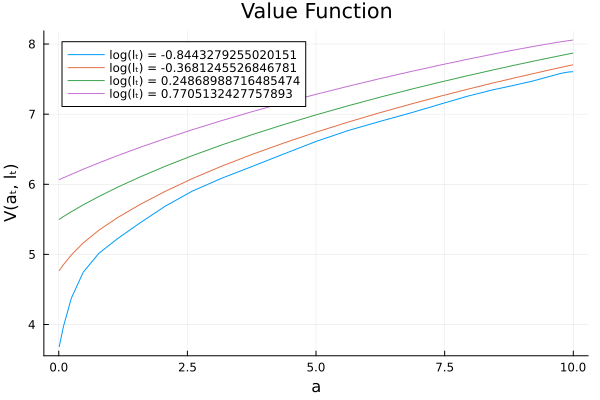

In [22]:
log_l_vals = [5, 10, 15, 20]

log_l = hh.log_l_grid[log_l_vals[1]]
v_func_p = plot(
    hh.a_grid, 
    v_func.(hh.a_grid, log_l),
    title="Value Function",
    xlabel = "a",
    ylabel = "V(aₜ, lₜ)",
    label = "log(lₜ) = $log_l"
)
for log_l_i in 2:length(log_l_vals)
    log_l = hh.log_l_grid[log_l_vals[log_l_i]]
    plot!(v_func_p, hh.a_grid, v_func.(hh.a_grid, log_l), label = "log(lₜ) = $log_l")
end

display(v_func_p)

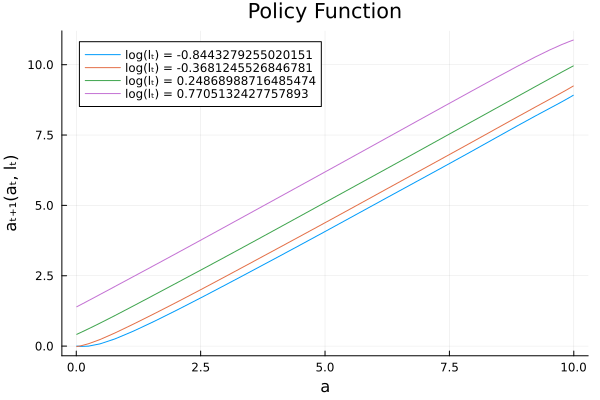

In [23]:
idx_l = log_l_vals[1]
log_l = hh.log_l_grid[idx_l]
policy_p = plot(
    hh.a_grid, 
    policy_func.(hh.a_grid, log_l),
    title="Policy Function",
    xlabel = "a",
    ylabel = "aₜ₊₁(aₜ, lₜ)",
    label = "log(lₜ) = $log_l"
)
for i in 2:length(log_l_vals)
    idx_l = log_l_vals[i]
    log_l = hh.log_l_grid[idx_l]
    plot!(policy_p, hh.a_grid, policy_func.(hh.a_grid, log_l), label = "log(lₜ) = $log_l") 
end

display(policy_p)

# Equilibrium Construction

Given an interest rate $r$, solve the household optimization problem and calculate the policy function $a_{t+1}\left(a_t, l_t\right)$. Then Simulate the economy, and get the distribution for asset $a$. In equilibrium, the capital demand from firms $\left(\frac{\alpha}{r + \delta}\right)^{\frac{1}{1-\alpha}}$ should be equal to the supply of capital from households, i.e. the assets.

Using bisection, we find for the equilibrium interest rate $r$.

In [31]:
function simulate_excess_capital(
        r::Float64,
        hh::HHModel, 
        policy_func,
        n_hh::Int64=5_000, n_sim::Int64=2_000, burn_out::Int64=500
    )

    hh_labor_list = randn(n_hh) * (hh.settings.ρ * hh.settings.σ_ϵ)
    hh_asset_list = zeros(n_hh)

    p = Progress(n_sim - 1; desc="Simulating r=$r:")
    for i in 2:n_sim
        shock_vec = (randn(n_hh) .+ hh.settings.μ_ϵ) .* hh.settings.σ_ϵ
        hh_labor_list .= log_labor_process.(hh_labor_list, shock_vec, Ref(hh.settings))
        hh_asset_list .= policy_func.(hh_asset_list, hh_labor_list)
        next!(p)
    end

    return mean(filter(!isnan, hh_asset_list[burn_out:end])) - capital_demand(r, hh.settings)
    return hh_asset_list
end;

In [32]:
function bisection_search!(
        r_min, r_max, hh::HHModel,
        n_hh::Int64 = 5_000, n_sim::Int64 = 2_000, burn_out::Int64=500, tol::Float64=1e-4
    )

    
    r_mid = (r_min + r_max) / 2
    
    if abs(r_max - r_min) <= tol
        return r_mid
    end


    _, policy_func = solve_household_VFI!(r_mid, hh, false)
    # hh = copy(hh)

    excess_capital = simulate_excess_capital(r_mid, hh, policy_func, n_hh, n_sim, burn_out)
    println("r: $r_mid, excess capital: $excess_capital\n")
    if excess_capital < 0
        return bisection_search!(r_mid, r_max, hh, n_hh, n_sim, burn_out, tol)
    else
        return bisection_search!(r_min, r_mid, hh, n_hh, n_sim, burn_out, tol)
    end
    
end;

In [33]:
hh = intiate_hh_model(modelSetting);
bisection_search!(0.01, 0.5, hh)

ω: 0.6664421038424136


Value Function Iteration Convergence: Time: 0:00:07 (264 iterations)5)


Value Function Iteration converged in 264 iterations with error: 9.762742164909355e-6.


Simulating r=0.255: 100%|████████████████████████████████| Time: 0:00:01


r: 0.255, excess capital: 8.701948567321505

ω: 0.8609159026275437


Value Function Iteration Convergence: Time: 0:00:06 (215 iterations)5)


Value Function Iteration converged in 215 iterations with error: 9.654456995633609e-6.


Simulating r=0.1325: 100%|███████████████████████████████| Time: 0:00:01


r: 0.1325, excess capital: 7.587328380155881

ω: 1.0423689773048115


Value Function Iteration Convergence: Time: 0:00:07 (214 iterations)5)


Value Function Iteration converged in 214 iterations with error: 9.950115982704233e-6.


Simulating r=0.07125000000000001: 100%|██████████████████| Time: 0:00:01


r: 0.07125000000000001, excess capital: 5.636340725141516

ω: 1.1838362508544054


Value Function Iteration Convergence: Time: 0:00:07 (186 iterations)5)


Value Function Iteration converged in 186 iterations with error: 9.794208268409932e-6.


Simulating r=0.040625: 100%|█████████████████████████████| Time: 0:00:01


r: 0.040625, excess capital: -0.07126530055723812

ω: 1.1068704325291885


Value Function Iteration Convergence: Time: 0:00:06 (173 iterations)5)


Value Function Iteration converged in 173 iterations with error: 9.929132008146269e-6.


Simulating r=0.0559375: 100%|████████████████████████████| Time: 0:00:01


r: 0.0559375, excess capital: 4.4369343002289785

ω: 1.1435583784175674


Value Function Iteration Convergence: Time: 0:00:06 (159 iterations)5)


Value Function Iteration converged in 159 iterations with error: 9.694559416573156e-6.


Simulating r=0.04828125: 100%|███████████████████████████| Time: 0:00:01


r: 0.04828125, excess capital: 3.1850847336028476

ω: 1.1632133147455124


Value Function Iteration Convergence: Time: 0:00:05 (130 iterations)5)


Value Function Iteration converged in 130 iterations with error: 9.810240874763565e-6.


Simulating r=0.044453124999999996: 100%|█████████████████| Time: 0:00:01


r: 0.044453124999999996, excess capital: 1.8833264416784106

ω: 1.1733989476437428


Value Function Iteration Convergence: Time: 0:00:04 (102 iterations)5)


Value Function Iteration converged in 102 iterations with error: 9.986685260976458e-6.


Simulating r=0.0425390625: 100%|█████████████████████████| Time: 0:00:01


r: 0.0425390625, excess capital: 0.998844934651208

ω: 1.178585506451769


Value Function Iteration Convergence: Time: 0:00:03 (98 iterations)05)


Value Function Iteration converged in 98 iterations with error: 9.75391142610249e-6.


Simulating r=0.04158203125: 100%|████████████████████████| Time: 0:00:01


r: 0.04158203125, excess capital: 0.544565583640491

ω: 1.1812027742521374


Value Function Iteration Convergence: Time: 0:00:03 (88 iterations)05)


Value Function Iteration converged in 88 iterations with error: 9.720949923686106e-6.


Simulating r=0.041103515625: 100%|███████████████████████| Time: 0:00:01


r: 0.041103515625, excess capital: 0.27741681219773096

ω: 1.1825174761776183


Value Function Iteration Convergence: Time: 0:00:03 (76 iterations)05)


Value Function Iteration converged in 76 iterations with error: 9.768456212810861e-6.


Simulating r=0.0408642578125: 100%|██████████████████████| Time: 0:00:01


r: 0.0408642578125, excess capital: 0.07314133281743018

ω: 1.18317635312974


Value Function Iteration Convergence: Time: 0:00:02 (64 iterations)05)


Value Function Iteration converged in 64 iterations with error: 9.619301705843242e-6.


Simulating r=0.04074462890625: 100%|█████████████████████| Time: 0:00:01


r: 0.04074462890625, excess capital: 0.06028653498576109

ω: 1.1835061742334605


Value Function Iteration Convergence: Time: 0:00:02 (52 iterations)05)


Value Function Iteration converged in 52 iterations with error: 9.595314007349032e-6.


Simulating r=0.040684814453124996: 100%|█████████████████| Time: 0:00:01


r: 0.040684814453124996, excess capital: 0.019040632519993217



0.040654907226562495